In [9]:
import math
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt 

from datetime import datetime
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
plt.style.use('classic')

In [10]:
lt = pdr.DataReader('LT.BO', data_source='yahoo', start='2015-10-23', end='2019-12-30')

In [11]:
lt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1027 entries, 2015-10-23 to 2019-12-30
Data columns (total 6 columns):
High         1027 non-null float64
Low          1027 non-null float64
Open         1027 non-null float64
Close        1027 non-null float64
Volume       1027 non-null float64
Adj Close    1027 non-null float64
dtypes: float64(6)
memory usage: 56.2 KB


In [12]:
lt.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-10-23,1046.900024,1004.330017,1043.329956,1006.869995,392608.0,927.473083
2015-10-26,1020.000000,1003.330017,1015.669983,1005.429993,240930.0,926.146545
2015-10-27,1015.270020,993.700012,1003.330017,996.200012,336750.0,917.644470
2015-10-28,999.666992,989.267029,993.333008,994.267029,255129.0,915.863892
2015-10-29,998.767029,978.000000,998.533020,981.067017,362704.0,903.704773


In [13]:
# we shall use the adjusted close because it takes into account all the 
# activites that have happened after the market closes
# such as any announcements the company made or any dividends
# it announced.

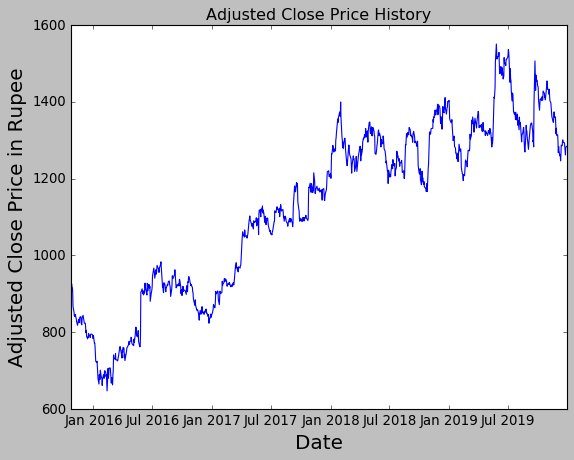

<Figure size 1600x800 with 0 Axes>

In [14]:
# visualize the adj. closing price history
plt.title('Adjusted Close Price History')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adjusted Close Price in Rupee', fontsize=18)
plt.plot(lt['Adj Close'])
plt.figure(figsize=(20,10))
plt.show()

In [16]:
#creating dataframe with only Adj Close
data = lt.filter(['Adj Close'])
#convert to numpy array
dataset = data.values
#using 10% of data to train and other 10% to test
training_data_len = math.floor(len(dataset)*0.9)

In [17]:
#normalizing the data is very important because LSTM is very sensisitive
#to the scale of the data
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)

In [18]:
#create the scaled training dataset
data_for_training = scaled_data[0:training_data_len]

#split into train and test dataset
x_train, y_train = [], []

for i in range(0,len(data_for_training)-60):
    x_train.append(data_for_training[i:i+60,0])
    y_train.append(data_for_training[i+60,0])


In [19]:
#convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train),np.array(y_train)

In [20]:
#reshape as LSTM needs 3D input 
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))


In [21]:
x_train.shape

(864, 60, 1)

In [48]:
#building stacked LSTM model
model = Sequential()
model.add(LSTM(70, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.1))
model.add(LSTM(70,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(70))
model.add(Dense(1))

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 70)            20160     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 70)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 60, 70)            39480     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 70)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 70)                39480     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 71        
Total params: 99,191
Trainable params: 99,191
Non-trainable params: 0
__________________________________________________

In [50]:
#compiling the model
model.compile(optimizer = 'adam',loss='mean_absolute_error',metrics=['mean_absolute_error'])

In [51]:
#training the model
history = model.fit(x_train, y_train,epochs=50, batch_size = 50)

Epoch 1/50
864/864 [==============================] - 3s 4ms/step - loss: 0.1384 - mean_absolute_error: 0.1384
Epoch 2/50
864/864 [==============================] - 2s 2ms/step - loss: 0.0490 - mean_absolute_error: 0.0490
Epoch 3/50
864/864 [==============================] - 2s 2ms/step - loss: 0.0428 - mean_absolute_error: 0.0428
Epoch 4/50
864/864 [==============================] - 2s 2ms/step - loss: 0.0447 - mean_absolute_error: 0.0447
Epoch 5/50
864/864 [==============================] - 2s 2ms/step - loss: 0.0457 - mean_absolute_error: 0.0457
Epoch 6/50
864/864 [==============================] - 2s 2ms/step - loss: 0.0390 - mean_absolute_error: 0.0390
Epoch 7/50
864/864 [==============================] - 2s 2ms/step - loss: 0.0372 - mean_absolute_error: 0.0372
Epoch 8/50
864/864 [==============================] - 2s 2ms/step - loss: 0.0411 - mean_absolute_error: 0.0411
Epoch 9/50
864/864 [==============================] - 2s 2ms/step - loss: 0.0349 - mean_absolute_error: 0.0349
E

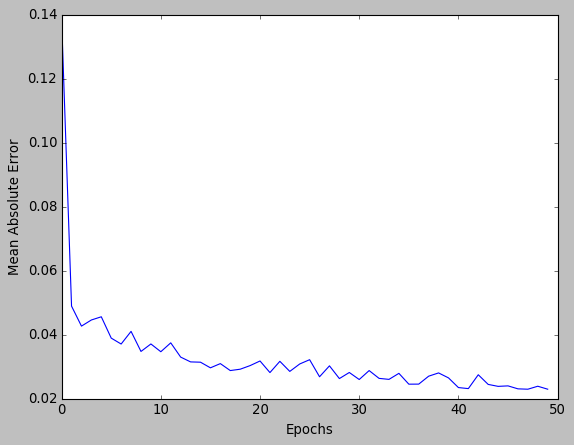

In [52]:
history_dict = history.history

plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.plot(history_dict['mean_absolute_error'])
plt.show()

In [53]:
len(scaled_data)

1027

In [54]:
training_data_len

924

In [55]:
# create the testing dataset
test_data = scaled_data[training_data_len-60: , :] # because x_test ended at the index training_data_len - 60


In [56]:
y_test = dataset[training_data_len:, :] # actual data


In [57]:
len(y_test)

103

In [58]:
x_test = []
for i in range(0,len(test_data)-60):
    x_test.append(test_data[i:i+60,0])

In [59]:
len(x_test)

103

In [60]:
x_test = np.array(x_test)

In [61]:
x_test.shape

(103, 60)

In [62]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [63]:
x_test.shape

(103, 60, 1)

In [64]:
predictions = model.predict(x_test)

In [65]:
predictions.shape

(103, 1)

In [66]:
y_test.shape

(103, 1)

In [67]:
predictions = scaler.inverse_transform(predictions)

In [68]:
mae = np.mean(np.abs(predictions-y_test))

In [69]:
mae

23.054893715867717

In [70]:
len(predictions)

103

In [71]:
math.sqrt(mean_squared_error(y_test,predictions))


34.984968911602635

/home/terminatorash2199/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


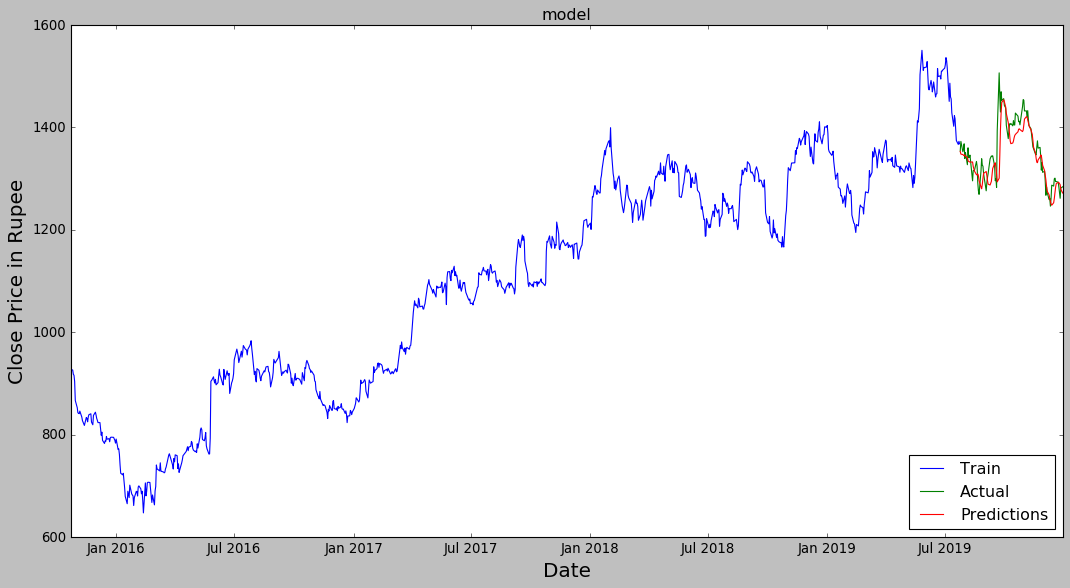

In [72]:
# plot the data
train = data[:training_data_len]
actual = data[training_data_len:]
actual['Predictions'] = predictions

# visualize the data
plt.figure(figsize=(16,8))
plt.title("model")
plt.xlabel('Date', fontsize =18)
plt.ylabel('Close Price in Rupee', fontsize=18)

plt.plot(train['Adj Close'])
plt.plot(actual[['Adj Close','Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()

In [73]:
actual

,Adj Close,Predictions
Date,,
2019-07-25,1353.978638,1353.000732
2019-07-26,1372.617554,1347.776733
2019-07-29,1352.548706,1347.067505
2019-07-30,1357.430298,1345.650635
2019-07-31,1367.982544,1344.681274
2019-08-01,1339.185913,1346.370850
2019-08-02,1351.069458,1343.870361
2019-08-05,1327.105225,1341.226685
2019-08-06,1360.142334,1334.810181
